# Business Case - Data Scientist  

## Made by Schékina MAYENE

## 10 Novembre 2023

# Objectif de l'étude 

Une companie de téléphonie fait face à un problème de désabonnnement de ses clients. Elle nous demande de :

>- Classer ses clients selon leurs probabilités de désabonnement
>- Identifier les clients qu'elle doit contacter et la rémise adaptée qu'elle doit proposer

# Plan d'analyse 

1-) **Inspection de la base de données :**
dimension, noms des variables, présence si valeurs manquantes, 
recodage des variables catégorielles

2-) **Analyses statistiques :**
* Analyse univariée : Représentations graphiques des variables, identification des types de distribution pour les variables quantitatives
* Analyse bivariées : test de khi-2 pour les variables qualitatives,test de corrélation et etc...

3-) **Machine Learning:**
* Division de la base de données
* entrainement et test du modèle
* Evaluation du modèle : Métrique choisie : AUC Score 
* Optimisation : gridSearcCV
* Prédiction sur le jeux de données

4-) **Réponses aux problématiques**
* Classement des clients selon leurs probabilités de désabonnement
* Proposition des discounts

In [41]:
# chargement des librairies 

import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm #qq-plot
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
# Importation de la base de données d'entraînement

data_train = pd.read_csv("training.csv", 
                        sep = ',',
                        header = 0)

# Apperçue de la base de données 

data_train.head(10)

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,zero,660.000000,19995.0,0,0,897338.0,False,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY
1,C100001,one,317.647059,31477.0,155,15,393396.0,True,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE
2,C100006,zero,208.695652,66742.0,0,13,937197.0,False,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY
3,C100008,zero,265.017668,40864.0,183,0,986430.0,False,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE
4,C100010,one,440.000000,43321.5,200,0,394622.0,True,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE
5,C100011,one,840.000000,18786.5,0,15,475819.0,True,1,2,143.0,187,0,3.8,4,very_unsat,very_high,actively_looking_into_it,STAY
6,C100012,zero,264.000000,46515.5,0,15,150498.0,True,3,1,191.0,363,1,3.2,4,very_unsat,very_high,never_thought,STAY
7,C100013,one,141.065831,90444.5,168,37,183605.0,True,5,3,217.0,539,28,2.0,2,very_sat,very_high,no,STAY
8,C100014,zero,483.870968,94779.5,179,0,677946.0,False,1,2,204.0,208,23,2.5,11,very_unsat,high,considering,LEAVE
9,C100015,one,276.315789,64602.5,204,24,270004.0,True,0,1,167.0,313,16,1.8,4,very_unsat,little,considering,STAY


# 1-) Inspection et nettoyage de la base de données

In [123]:
# Dimension

data_train.shape

(11346, 19)

In [5]:
# structure 

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CUSTOMER_ID                  11981 non-null  object 
 1   COLLEGE                      11981 non-null  object 
 2   DATA                         11981 non-null  float64
 3   INCOME                       11981 non-null  float64
 4   OVERCHARGE                   11981 non-null  int64  
 5   LEFTOVER                     11981 non-null  int64  
 6   HOUSE                        11346 non-null  float64
 7   LESSTHAN600k                 11346 non-null  object 
 8   CHILD                        11981 non-null  int64  
 9   JOB_CLASS                    11981 non-null  int64  
 10  REVENUE                      11981 non-null  float64
 11  HANDSET_PRICE                11981 non-null  int64  
 12  OVER_15MINS_CALLS_PER_MONTH  11981 non-null  int64  
 13  TIME_CLIENT     

 Avons nous des valeurs manquantes dans notre base de données ?

In [6]:
pd.isnull(data_train).sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

Nous constatons que pour les variables **HOUSE** et **LESSTHAN600K** nous avons **635** valeurs manquantes. Etant donné que ces observations ne répresentent que 5% des enregistrements de notre base, nous décidons de les supprimer . 

Notons que nous aurions pu aussi remplacer ces données manquantes par la médiane de la variable HOUSE ou encore utiliser l'algorithme des K-Neirest Neighbor afin de les imputer.

In [7]:
# Suppression des valeurs manquantes 

data_train = data_train.loc[pd.isnull(data_train.HOUSE)== False , ]

# Varification 

data_train.shape

(11346, 19)

In [8]:
# Colonnes de la base de données
data_train.columns

Index(['CUSTOMER_ID', 'COLLEGE', 'DATA', 'INCOME', 'OVERCHARGE', 'LEFTOVER',
       'HOUSE', 'LESSTHAN600k', 'CHILD', 'JOB_CLASS', 'REVENUE',
       'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT',
       'AVERAGE_CALL_DURATION', 'REPORTED_SATISFACTION',
       'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN', 'CHURNED'],
      dtype='object')

**Recodage des variables catégorielles**

In [9]:
data_train.loc[data_train.COLLEGE == 'zero', 'COLLEGE'] = 0
data_train.loc[data_train.COLLEGE == 'one', 'COLLEGE'] = 1


data_train.loc[data_train.LESSTHAN600k == False, 'LESSTHAN600k'] = 0
data_train.loc[data_train.LESSTHAN600k == True, 'LESSTHAN600k'] = 1


data_train.loc[data_train.REPORTED_SATISFACTION == 'very_unsat', 'REPORTED_SATISFACTION'] = 1
data_train.loc[data_train.REPORTED_SATISFACTION == 'unsat', 'REPORTED_SATISFACTION'] = 2
data_train.loc[data_train.REPORTED_SATISFACTION == 'avg', 'REPORTED_SATISFACTION'] = 3
data_train.loc[data_train.REPORTED_SATISFACTION == 'sat', 'REPORTED_SATISFACTION'] = 4
data_train.loc[data_train.REPORTED_SATISFACTION == 'very_sat', 'REPORTED_SATISFACTION'] = 5

data_train.loc[data_train.REPORTED_USAGE_LEVEL == 'very_little', 'REPORTED_USAGE_LEVEL'] = 1
data_train.loc[data_train.REPORTED_USAGE_LEVEL == 'little', 'REPORTED_USAGE_LEVEL'] = 2
data_train.loc[data_train.REPORTED_USAGE_LEVEL == 'avg', 'REPORTED_USAGE_LEVEL'] = 3
data_train.loc[data_train.REPORTED_USAGE_LEVEL == 'high', 'REPORTED_USAGE_LEVEL'] = 4
data_train.loc[data_train.REPORTED_USAGE_LEVEL == 'very_high', 'REPORTED_USAGE_LEVEL'] = 5

data_train.loc[data_train.CONSIDERING_CHANGE_OF_PLAN == 'actively_looking_into_it', 'CONSIDERING_CHANGE_OF_PLAN'] = 1
data_train.loc[data_train.CONSIDERING_CHANGE_OF_PLAN == 'considering', 'CONSIDERING_CHANGE_OF_PLAN'] = 2
data_train.loc[data_train.CONSIDERING_CHANGE_OF_PLAN == 'perhaps', 'CONSIDERING_CHANGE_OF_PLAN'] = 3
data_train.loc[data_train.CONSIDERING_CHANGE_OF_PLAN == 'no', 'CONSIDERING_CHANGE_OF_PLAN'] = 4
data_train.loc[data_train.CONSIDERING_CHANGE_OF_PLAN == 'never_thought', 'CONSIDERING_CHANGE_OF_PLAN'] = 5

data_train.loc[data_train.CHURNED == 'STAY', 'CHURNED'] = 1
data_train.loc[data_train.CHURNED == 'LEAVE', 'CHURNED'] = 0




In [10]:
# Vérification 

data_train

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,0,660.000000,19995.0,0,0,897338.0,0,4,3,160.0,155,1,1.2,15,1,2,2,1
1,C100001,1,317.647059,31477.0,155,15,393396.0,1,0,1,100.0,245,27,2.7,4,2,2,2,0
2,C100006,0,208.695652,66742.0,0,13,937197.0,0,4,2,127.0,493,20,2.6,4,3,1,2,1
3,C100008,0,265.017668,40864.0,183,0,986430.0,0,3,3,86.0,390,13,2.5,12,2,5,2,0
4,C100010,1,440.000000,43321.5,200,0,394622.0,1,2,3,77.0,175,18,2.4,10,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,C115967,1,829.787234,40567.0,41,7,458723.0,1,0,4,128.0,305,5,3.9,4,3,2,1,1
11977,C115968,0,723.529412,75007.5,70,0,328171.0,1,3,1,199.0,610,5,4.1,13,2,2,1,0
11978,C115970,0,80.000000,77674.5,0,80,439967.0,1,3,1,94.0,750,1,1.4,1,2,2,1,0
11979,C115972,0,77.777778,37730.5,0,17,795808.0,0,3,1,142.0,284,0,1.7,8,1,2,2,1


**Résumé des changements opérés pour les variables qualitatives**

LESSTHAN600k 
>- 0 : False
>- 1 : True

REPORTED_SATISFACTION 
>- 1: very_unsat
>- 2: unsat
>- 3 avg
>- 4 sat
>- 5 very_sat

REPORTED_USAGE_LEVEL 
>- 1: very_little
>- 2: little
>- 3 avg
>- 4 high
>- 5 very_high

 
CONSIDERING_CHANGE_OF_PLAN 
>- 1: actively_looking_into_it
>- 2: considering
>- 3 perhaps
>- 4 no
>- 5 never_thought

CHURNED
>- 1: STAY
>- 0: LEAVE

**Changement du type des variables catégorielles** 

In [11]:
variables_cat = ["COLLEGE", "LESSTHAN600k","REPORTED_SATISFACTION", "REPORTED_USAGE_LEVEL", 
                 "CONSIDERING_CHANGE_OF_PLAN", "CHURNED", "JOB_CLASS" ]

for i in variables_cat :
    data_train[i] = data_train[i].astype("category")
    
    

In [12]:
#SPécification des variables catégorielles ordonnées

categories_order = [1,2,3,4,5]

data_train['REPORTED_SATISFACTION'] = pd.Categorical(data_train['REPORTED_SATISFACTION'], categories=categories_order, ordered=True)
data_train['REPORTED_USAGE_LEVEL'] = pd.Categorical(data_train['REPORTED_USAGE_LEVEL'], categories=categories_order, ordered=True)
data_train['CONSIDERING_CHANGE_OF_PLAN'] = pd.Categorical(data_train['CONSIDERING_CHANGE_OF_PLAN'], categories=categories_order, ordered=True)

In [13]:
# vérification du changement

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11346 entries, 0 to 11980
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   CUSTOMER_ID                  11346 non-null  object  
 1   COLLEGE                      11346 non-null  category
 2   DATA                         11346 non-null  float64 
 3   INCOME                       11346 non-null  float64 
 4   OVERCHARGE                   11346 non-null  int64   
 5   LEFTOVER                     11346 non-null  int64   
 6   HOUSE                        11346 non-null  float64 
 7   LESSTHAN600k                 11346 non-null  category
 8   CHILD                        11346 non-null  int64   
 9   JOB_CLASS                    11346 non-null  category
 10  REVENUE                      11346 non-null  float64 
 11  HANDSET_PRICE                11346 non-null  int64   
 12  OVER_15MINS_CALLS_PER_MONTH  11346 non-null  int64   
 13  TIME_C

# 2-) Analyse descriptives univariée et bivariée

## 2- 1/ Analyse univariée 

**Variables catégorielles**

Pour ces variables, nous optons pour 2 types de graphiques pour les représenter : le diagramme circulaire pour les variables catégorielles à 2 catégories et le diagramme en barre pour les variables catégorielles à plus de 2 catégories

In [14]:
variables_cat

['COLLEGE',
 'LESSTHAN600k',
 'REPORTED_SATISFACTION',
 'REPORTED_USAGE_LEVEL',
 'CONSIDERING_CHANGE_OF_PLAN',
 'CHURNED',
 'JOB_CLASS']

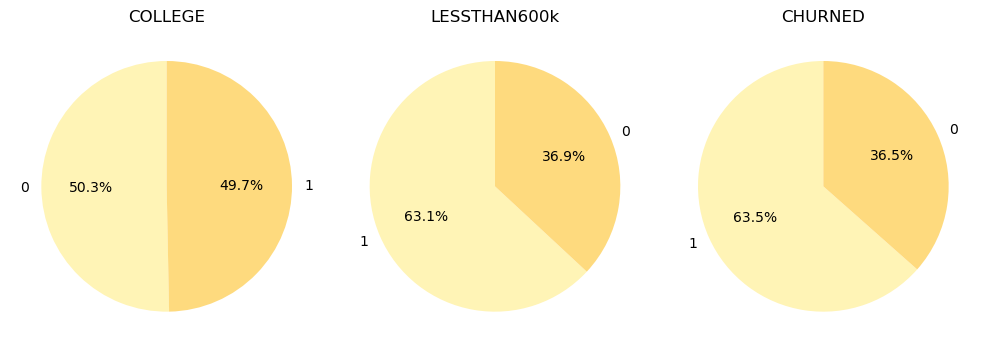

In [19]:
# Diagramme circulaire des variables à deux modalités

variables_cat_bin= ['COLLEGE','LESSTHAN600k','CHURNED']

fig, axes = plt.subplots(1,3, figsize = (10,6))

axes = axes.flatten()

for i, var in enumerate(variables_cat_bin):
    counts = data_train[var].value_counts()
    axes[i].pie(counts, labels = counts.index, autopct = "%1.1f%%", startangle =90, colors = sns.color_palette("YlOrBr"))
    axes[i].set_title(f"{var}")
    
plt.tight_layout()
plt.show()

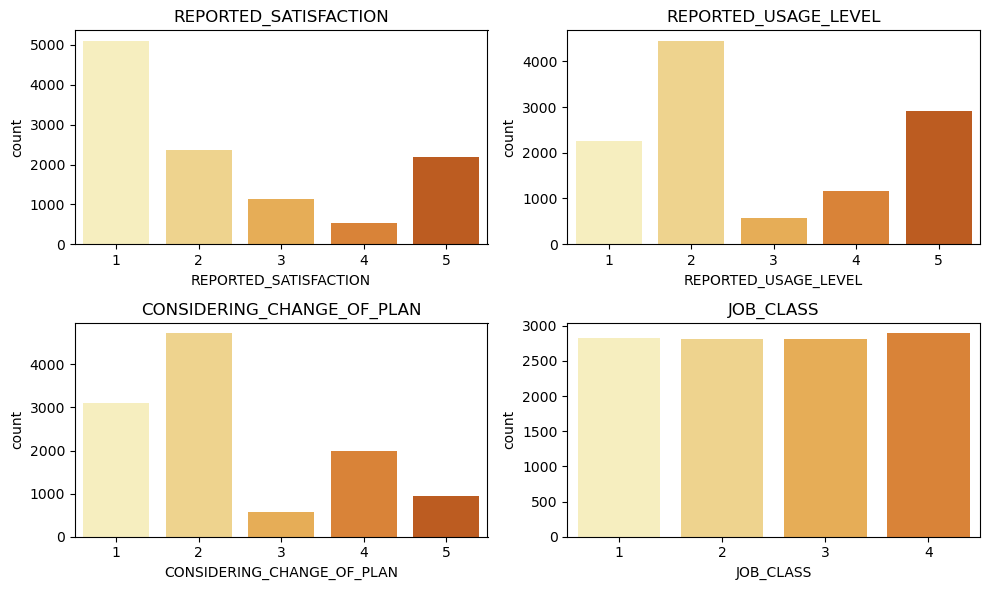

In [23]:
# Diagramme en barre des variables à plus de 2 modalités

variables_cat_nonbin = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN', 'JOB_CLASS']

fig,axes = plt.subplots(2,2, figsize=(10,6))

axes = axes.flatten()

for i,var in enumerate(variables_cat_nonbin) :
    counts = data_train[var].value_counts()
    sns.barplot(x = counts.index, y = counts, ax = axes[i], palette = sns.color_palette("YlOrBr"))
    axes[i].set_title(var)

plt.tight_layout()
plt.show()

D'après les observations ci-dessus, nous voyons que parmis les anciens clients de l'entreprise TELCO : 

>- La moitié n'a pas suivi de cursus universitaire
>- Plus de la moitié possède une maison d'un montant de plus de 600k
>- Plus de la moitié de ces clients ne se sont pas désabonnés au service de l'entreprise 
>- La plupart d'entre eux utilisent un peu les services, sont très insastisfait de ceux-ci et envisage l'idée d'aller voir ailleurs  

**Variables quantitatives** 

Pour ce type de variable, nous optons pour des boites à moustaches

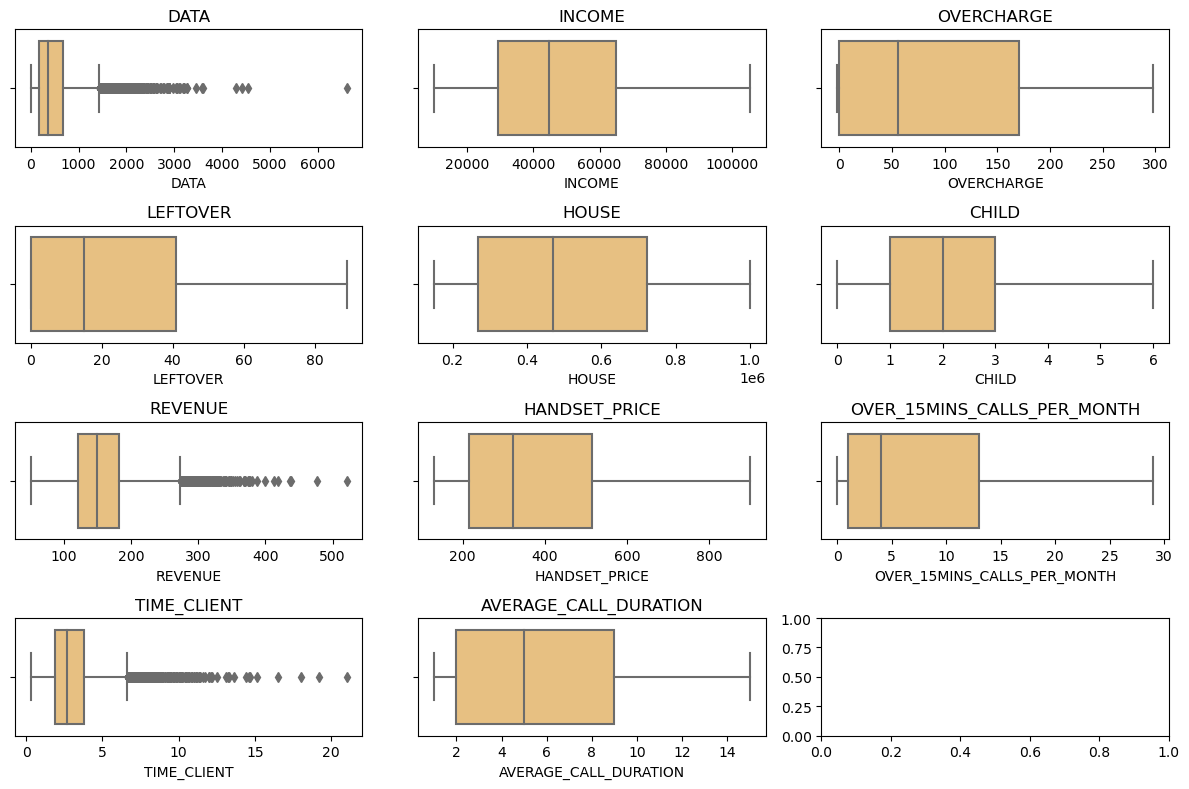

In [27]:
# graphique des variables quanti

variables_quanti = ['DATA', 'INCOME', 'OVERCHARGE', 'LEFTOVER',
       'HOUSE','CHILD', 'REVENUE','HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT',
       'AVERAGE_CALL_DURATION']

# Créer une figure avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(4, 3, figsize=(12, 8))

# Aplatir la liste des axes pour un accès facile
axes = axes.flatten()

for i, col in enumerate(variables_quanti):
    sns.boxplot(x = data_train[col], ax = axes[i], color = "#F8C471")
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()
    

In [31]:
# Summary des variables quantitatives

data_train.loc[:, variables_quanti].describe()



,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
count,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000
mean,503.381766,47554.643266,80.228627,23.857218,506521.681650,2.069364,155.497180,382.952142,7.525560,3.080407,5.967654
std,457.877611,22301.121475,84.648846,26.720440,256808.319571,1.251756,47.873219,210.254384,8.755728,1.651883,4.365952
min,0.000000,10032.500000,-2.000000,0.000000,150015.000000,0.000000,50.000000,130.000000,0.000000,0.300000,1.000000
25%,181.442686,29344.000000,0.000000,0.000000,268511.250000,1.000000,121.000000,216.250000,1.000000,1.900000,2.000000
50%,360.564416,44874.000000,56.000000,15.000000,469775.500000,2.000000,149.000000,322.000000,4.000000,2.700000,5.000000
75%,684.563758,65027.625000,171.000000,41.000000,722464.250000,3.000000,182.000000,513.750000,13.000000,3.800000,9.000000
max,6600.000000,105355.500000,298.000000,89.000000,999996.000000,6.000000,521.000000,899.000000,29.000000,21.000000,15.000000


D'après les observations ci-dessus, nous pouvons dire que  : 

>- 50% des anciens clients de TELCO avaient un abonnement supérieure à 150 euros l'année. Nous constatons également la présence de valeurs extrêmes pour cette variable (variable REVENUE). 

>- 25% seulement des anciens clients de l'entreprise effectuaient des appels d'une durée de 13 minutes ou plus

>- En moyenne les clients ont 2 enfants, utilisent 503 Mo pour leurs connexions internet par mois, gagnent en mpyenne **47554 euros** par année

**Analyse de la distribution des variables quantitatives**  

Dans cette partie nous allons essayer de voir si les distributions de nos variables quantitatives sont normales ou pas.
Pour cela nous nous aiderons :
>- Des histogrammes
>- Diagramme des quantiles (QQ-Plot)
>- Des tests de Normalité (Test de shapiro Wilk, test d'Agustino Pearson, Kolmogorov-Smirnov

In [35]:
variables_quanti

['DATA',
 'INCOME',
 'OVERCHARGE',
 'LEFTOVER',
 'HOUSE',
 'CHILD',
 'REVENUE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'TIME_CLIENT',
 'AVERAGE_CALL_DURATION']

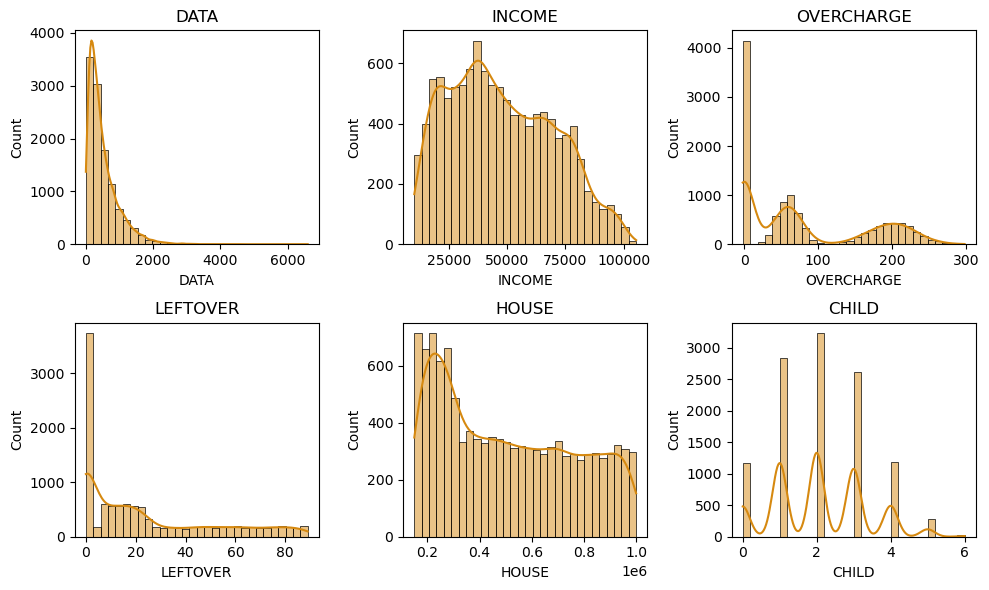

In [37]:
# Histogrammes 1

variables_quanti1 = ['DATA',
 'INCOME',
 'OVERCHARGE',
 'LEFTOVER',
 'HOUSE',
 'CHILD']

fig, axes = plt.subplots(2,3, figsize =(10,6))

axes = axes.flatten()

for i, var in enumerate(variables_quanti1):
    sns.histplot(x = data_train[var],bins = 30, kde= True, ax = axes[i], color = "#D68910")
    axes[i].set_title(var)
    
plt.tight_layout()
plt.show()

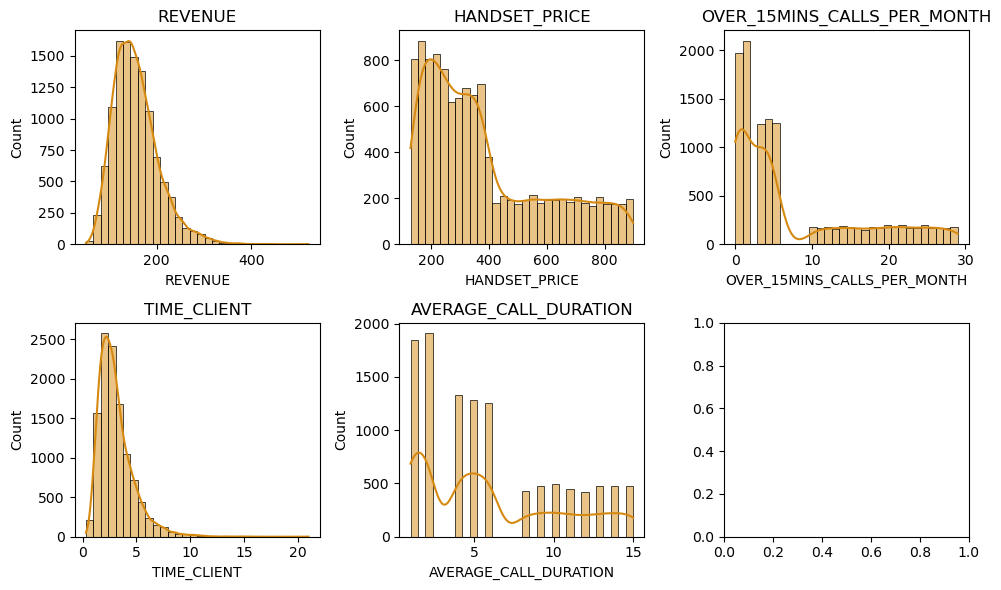

In [38]:
# Histogrammes 2

variables_quanti2 = ['REVENUE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'TIME_CLIENT',
 'AVERAGE_CALL_DURATION']

fig, axes = plt.subplots(2,3, figsize =(10,6))

axes = axes.flatten()

for i, var in enumerate(variables_quanti2):
    sns.histplot(x = data_train[var],bins = 30, kde= True, ax = axes[i], color = "#D68910")
    axes[i].set_title(var)
    
plt.tight_layout()
plt.show()

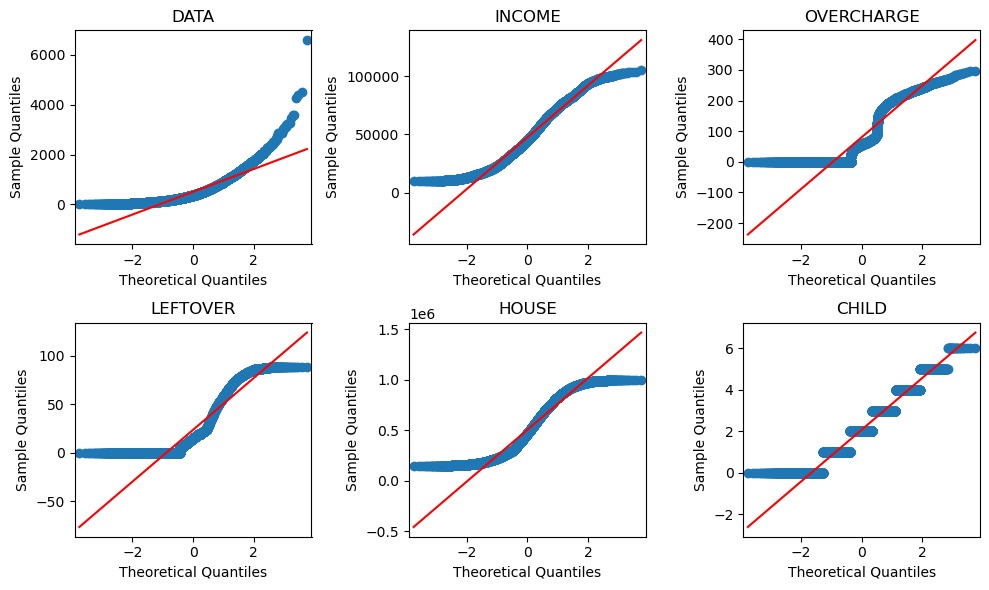

In [42]:
# QQ-PLOT1

fig, axes = plt.subplots(2,3 , figsize = (10,6))

axes = axes.flatten()

for i, var in enumerate(variables_quanti1):
    sm.qqplot(data_train[var], line = 's', ax = axes[i])
    axes[i].set_title(var)
    
plt.tight_layout()
plt.show()

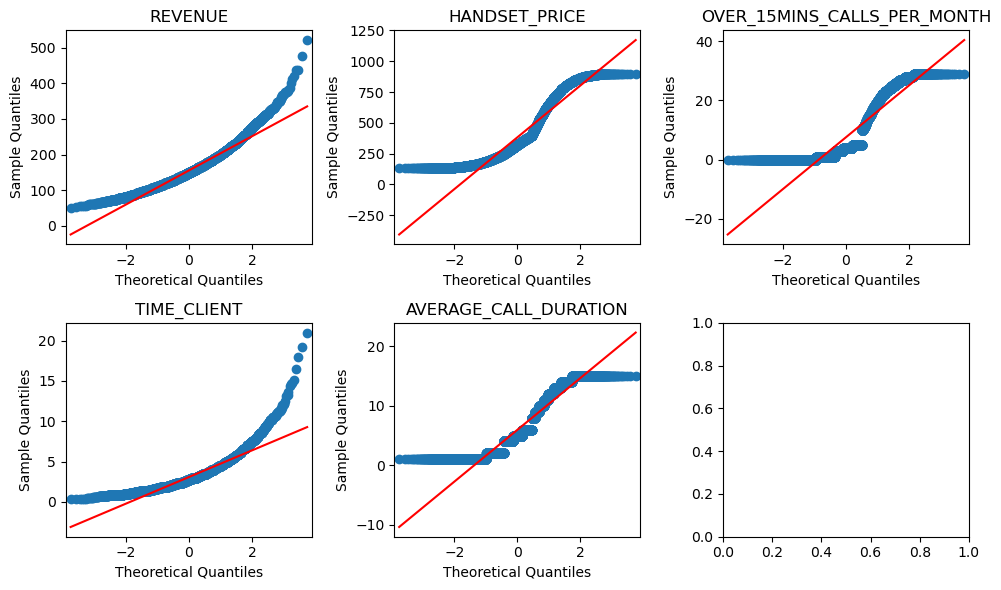

In [43]:
# QQ-PLOT2

fig, axes = plt.subplots(2,3 , figsize = (10,6))

axes = axes.flatten()

for i, var in enumerate(variables_quanti2):
    sm.qqplot(data_train[var], line = 's', ax = axes[i])
    axes[i].set_title(var)
    
plt.tight_layout()
plt.show()

In [49]:
# tests de Normalite

from scipy.stats import shapiro, normaltest, kstest

normalite_df = pd.DataFrame(columns = ["Variables_quant", "stat_test_shapiro", "p_value_shapiro", 
                                       "stat_test_KS", "p_value_KS"])

for var in variables_quanti :
    stat_shapiro, p_value_shap = shapiro(data_train[var])
    stat_KS, p_value_KS = kstest(data_train[var], 'norm')
    normalite_df.loc[len(normalite_df)] = [var,stat_shapiro, p_value_shap, stat_KS, p_value_KS]
    
# affichage

normalite_df

C:\Users\mayen\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\mayen\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\mayen\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\mayen\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\mayen\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\mayen\anaconda3\Lib\site-packages\sc

,Variables_quant,stat_test_shapiro,p_value_shapiro,stat_test_KS,p_value_KS
0,DATA,0.821805,0.000000e+00,0.992861,0.0
1,INCOME,0.968194,3.363116e-44,1.000000,0.0
2,OVERCHARGE,0.826431,0.000000e+00,0.634232,0.0
3,LEFTOVER,0.827100,0.000000e+00,0.670456,0.0
4,HOUSE,0.927197,0.000000e+00,1.000000,0.0
5,CHILD,0.933026,0.000000e+00,0.738754,0.0
6,REVENUE,0.951317,0.000000e+00,1.000000,0.0
7,HANDSET_PRICE,0.885879,0.000000e+00,1.000000,0.0
8,OVER_15MINS_CALLS_PER_MONTH,0.784791,0.000000e+00,0.667275,0.0
9,TIME_CLIENT,0.873528,0.000000e+00,0.844148,0.0


Les hypothèses des tests sur la normalité sont les suivantes : 

**H0: Les données suivent une distribution normale** VS **H1: Les données ne suivent pas une distribution normale.**

Nous constatons d'apres les resultats des test ci-dessus, aucune p-value de nos variables quantitatives n'est superieure au seuil de 0.05. Nous rejettons donc l'hypothèse nulle de normalité des distributions de nos variables

Les QQ-plots nous montrent également cette tendance de non normalité



## 2-2) Analyse bivariée

**Variables quantitatives - variables quantitatives**

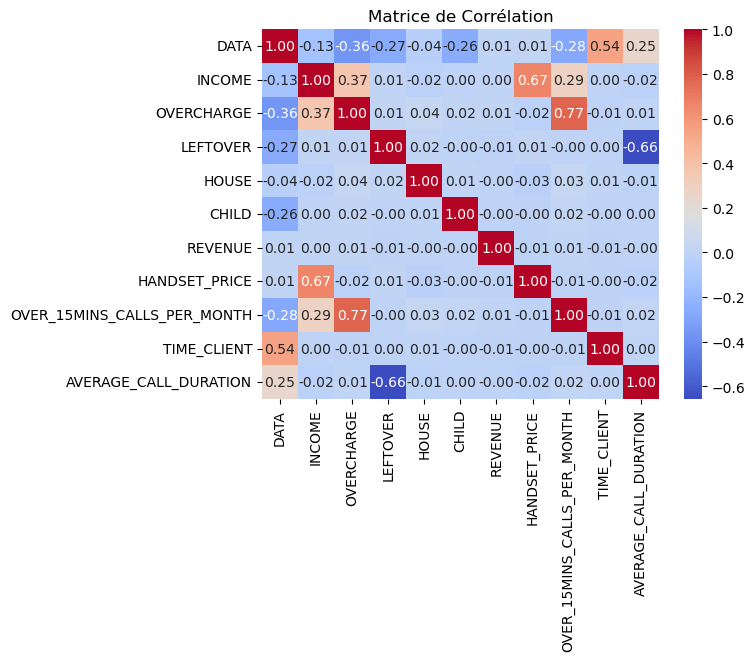

In [17]:
# Calculer la matrice de corrélation
correlation_matrix = data_train[variables_quanti].corr()

# Afficher la matrice de corrélation avec une heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Ajouter des étiquettes
plt.title('Matrice de Corrélation')
plt.show()

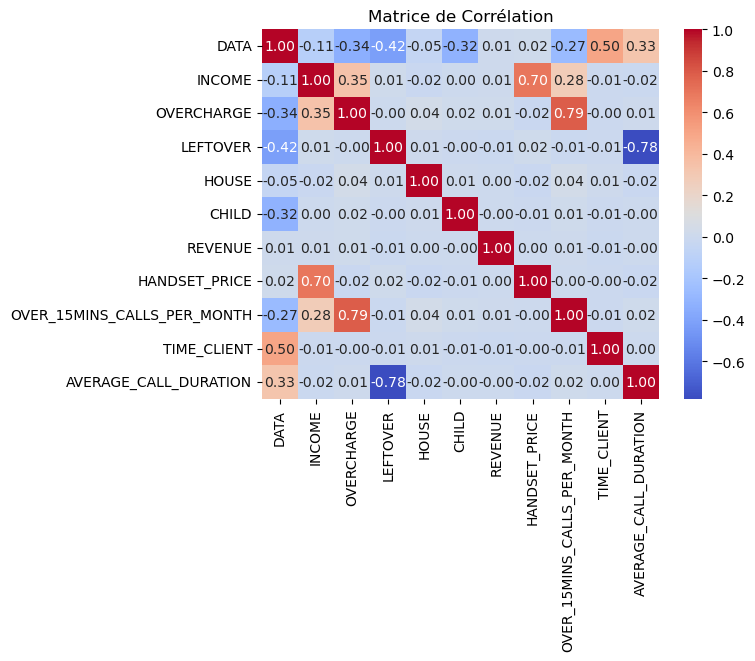

In [51]:
# Calculer la matrice de corrélation
correlation_matrix = data_train[variables_quanti].corr(method = "spearman")

# Afficher la matrice de corrélation avec une heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Ajouter des étiquettes
plt.title('Matrice de Corrélation de Spearman')
plt.show()

D'après le graphique ci-dessus, nous pouvons voir que : 

>- Il existe une assez bonne liaison positive entre les variables **OVER_15MINS_CALLS_PER_MONTH** et **OVERCHARGE**

Cela signifie que plus le client passe des longs appels par mois, plus ses surcharges augmentes

>- Il existe une assez bonne liaison positive entre les variables **HANDSET_PRICE** et **INCOME** (coef = 0,67)

Cela signifie que les personnes qui ont d'assez bon revenus ont endance à avoir des téléphones couteux

>- Il existe une assez bonne liaison négative entre les variables **AVERAGE_CALL_DURATION** et **LEFTOVER** (coef = -0,66)

Cela signifie que les peronnes qui passent plus de temps au téléphone sont les personnes qui laissent moins de minutes par mois
et cela est tout à fait logique

**Variable quantitatives - variable cible**

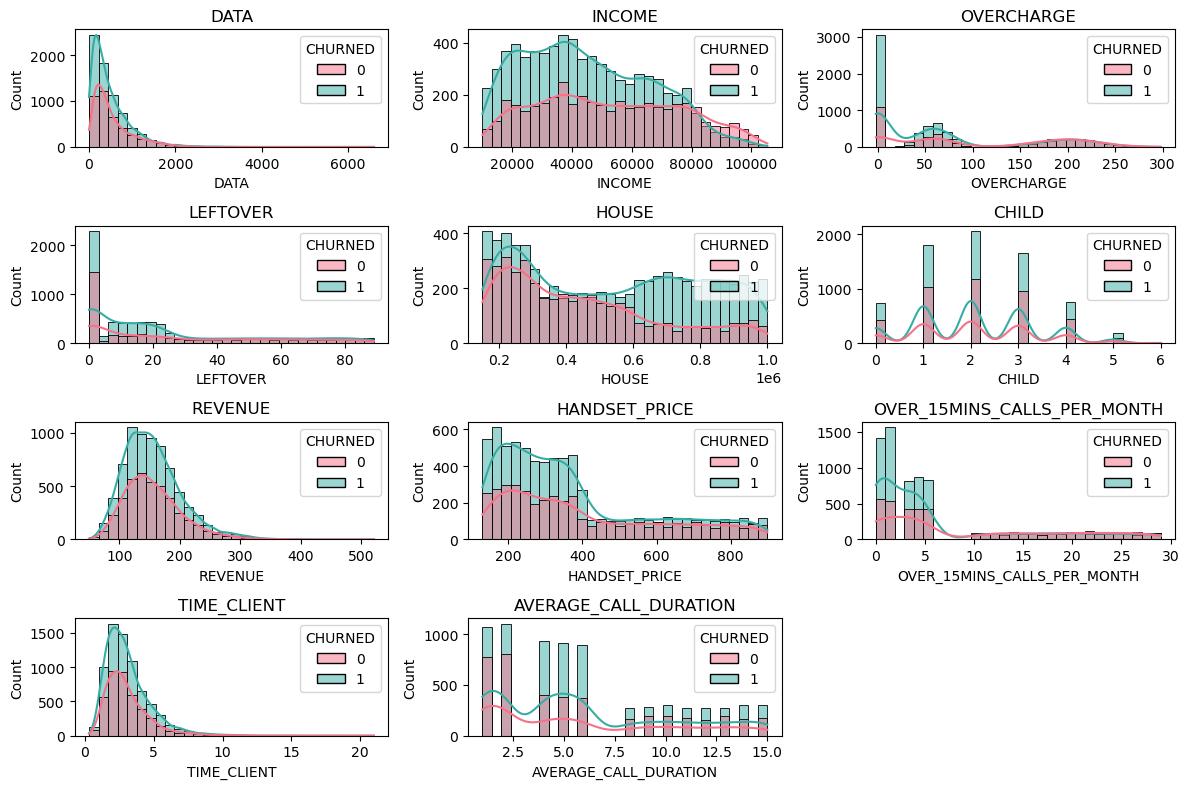

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))

# Aplatir la matrice d'axes pour faciliter l'itération
axes = axes.flatten()

# Enumérer à la fois les colonnes et les axes
for i, (col, ax) in enumerate(zip(variables_quanti, axes)):
    sns.histplot(x=data_train[col], ax=ax, hue=data_train['CHURNED'], bins=30, kde=True, palette='husl')
    ax.set_title(col)

# Supprimer les axes non utilisés
for j in range(len(variables_quanti), len(axes)):
    fig.delaxes(axes[j])

# Ajuster la disposition
plt.tight_layout()
plt.show()

Les résultats obtenus précedemment nous ont montrer que nos variables ne suivaient pas une loi normale. Ceci étant, nous utiliserons le test de **Mann-Whitney** qui est un test non paramétrique qui nous permet de comparer la moyenne de 2 groupes. 

Les hypothèses du test sont les suivantes :

**A retenir :**

**Comparaison de 2 groupes : test de student et test de Man-Whitney (test non paramétrique)
Comparaison de plus de 2 groupes : Annova ou Kruskal-Wallis(test non paramétrique**

**Variable catégorielles - variable cible**

In [31]:

from scipy.stats import chi2_contingency


# Créer un DataFrame pour stocker les résultats
resultats_df = pd.DataFrame(columns=['Variable_Catégorielle', 'Statistique_Chi2', 'P_Value', 'Cramer_V'])

# Itérer sur chaque variable catégorielle
for col in variables_cat: 
    # Créer une table de contingence
    contingence_table = pd.crosstab(data_train[col], data_train['CHURNED'])

    # Effectuer le test du chi-carré
    stat_chi2, p_value_chi2, _, _ = chi2_contingency(contingence_table)

    # Calculer le coefficient de Cramer
    n_obs = data_train.shape[0]
    min_dim = min(contingence_table.shape) - 1
    cramer_v = np.sqrt(stat_chi2 / (n_obs * min_dim))

     # Ajouter les résultats au DataFrame
    resultats_df.loc[len(resultats_df)] = [col, stat_chi2, p_value_chi2, cramer_v]

# Afficher le DataFrame des résultats
resultats_df


,Variable_Catégorielle,Statistique_Chi2,P_Value,Cramer_V
0,COLLEGE,0.481039,4.879521e-01,0.006511
1,LESSTHAN600k,635.238172,3.627224e-140,0.236618
2,REPORTED_SATISFACTION,574.635288,4.779736e-123,0.225048
3,REPORTED_USAGE_LEVEL,2.586004,6.293045e-01,0.015097
4,CONSIDERING_CHANGE_OF_PLAN,165.523988,9.549259e-35,0.120784
5,CHURNED,11341.687522,0.000000e+00,0.999810
6,JOB_CLASS,3.693225,2.965526e-01,0.018042


**Commentaires :**

# 3-) Machine learning

In [32]:
# Transformons nos variables catégorielles en variables binaires (Encodage ONE HOT)

data_train2 = pd.get_dummies(data_train, columns=['JOB_CLASS'], drop_first=False)

In [33]:
data_train3 = pd.get_dummies(data_train2, columns=['REPORTED_SATISFACTION'], drop_first=False)

In [34]:
data_train4 = pd.get_dummies(data_train3, columns=['REPORTED_USAGE_LEVEL'], drop_first=False)

In [35]:
data_train5 = pd.get_dummies(data_train4, columns=['CONSIDERING_CHANGE_OF_PLAN'], drop_first=False)

In [36]:
data_train5.iloc[:, 15:34] = data_train5.iloc[:, 15:34].astype(int)

In [37]:
# Vérification 

data_train5

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,REVENUE,...,REPORTED_USAGE_LEVEL_1,REPORTED_USAGE_LEVEL_2,REPORTED_USAGE_LEVEL_3,REPORTED_USAGE_LEVEL_4,REPORTED_USAGE_LEVEL_5,CONSIDERING_CHANGE_OF_PLAN_1,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4,CONSIDERING_CHANGE_OF_PLAN_5
0,C100000,0,660.000000,19995.0,0,0,897338.0,0,4,160.0,...,0,1,0,0,0,0,1,0,0,0
1,C100001,1,317.647059,31477.0,155,15,393396.0,1,0,100.0,...,0,1,0,0,0,0,1,0,0,0
2,C100006,0,208.695652,66742.0,0,13,937197.0,0,4,127.0,...,1,0,0,0,0,0,1,0,0,0
3,C100008,0,265.017668,40864.0,183,0,986430.0,0,3,86.0,...,0,0,0,0,1,0,1,0,0,0
4,C100010,1,440.000000,43321.5,200,0,394622.0,1,2,77.0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,C115967,1,829.787234,40567.0,41,7,458723.0,1,0,128.0,...,0,1,0,0,0,1,0,0,0,0
11977,C115968,0,723.529412,75007.5,70,0,328171.0,1,3,199.0,...,0,1,0,0,0,1,0,0,0,0
11978,C115970,0,80.000000,77674.5,0,80,439967.0,1,3,94.0,...,0,1,0,0,0,1,0,0,0,0
11979,C115972,0,77.777778,37730.5,0,17,795808.0,0,3,142.0,...,0,1,0,0,0,0,1,0,0,0


In [38]:
data_train5.CUSTOMER_ID = data_train5.CUSTOMER_ID.astype('category')

In [39]:
data_train5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11346 entries, 0 to 11980
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   CUSTOMER_ID                   11346 non-null  category
 1   COLLEGE                       11346 non-null  category
 2   DATA                          11346 non-null  float64 
 3   INCOME                        11346 non-null  float64 
 4   OVERCHARGE                    11346 non-null  int64   
 5   LEFTOVER                      11346 non-null  int64   
 6   HOUSE                         11346 non-null  float64 
 7   LESSTHAN600k                  11346 non-null  category
 8   CHILD                         11346 non-null  int64   
 9   REVENUE                       11346 non-null  float64 
 10  HANDSET_PRICE                 11346 non-null  int64   
 11  OVER_15MINS_CALLS_PER_MONTH   11346 non-null  int64   
 12  TIME_CLIENT                   11346 non-null  float

## 3-1) Entraînement du model

Pour réaliser notre modèle, nous décidons d'utiliser l'algorithme de **Random Forest**. Nous le choisissons lui au lieu de l'algorithme de Régression logistique par exemple parce qu'il ne tient pas que compte que des relation linéaire entre les *feature*s et le *Target*

Aussi Les Random Forests sont généralement moins sensibles aux valeurs aberrantes que la Régression Logistique, car les arbres de décision sont moins influencés par des observations individuelles.

In [40]:
X = data_train5.drop(['CUSTOMER_ID', 'CHURNED'], axis = 1)
y = data_train5['CHURNED']

In [41]:
# Division de la base de données en 2 ensembles : entraînement et test

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)

Pour tester ce premier modèle, nous choisissons arbitrairement l'hyper paramètre sur le nombre d'arbre à construire

In [42]:
# Entraînement model de Random Forest

rf_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [43]:
# prédictions 

y_pred = rf_model.predict(X_test)

In [49]:
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

L'aire sous la courbe ROC **(AUC)** est une mesure de la performance d'un modèle de classification binaire. Sur les résultats suivant, nous voyons que l'AUC = 0.841719.  

Ce score est un bon résultat parce que plus l'AUC est proche de 1 plus un modèle à une bonne capacité à discriminer entre les classes positives et négatives et c'est le cas pour notre modèle

In [50]:
# Calculer l'AUC
auc_value = roc_auc_score(y_test, y_pred_proba)
print(f"AUC : {auc_value}")


AUC : 0.8417190513369768


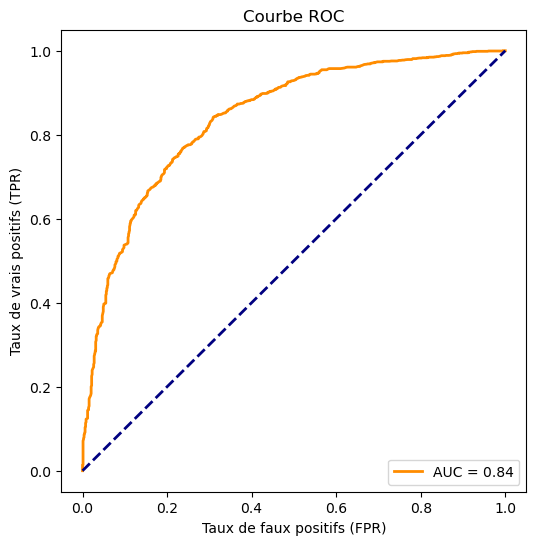

In [51]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

**Variables d'importances**

In [232]:
# Obtenir les variables d'importance
importances = rf_model.feature_importances_

# Créer un DataFrame pour visualiser les variables d'importance
feature_importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': importances
})

# Trier le DataFrame par ordre d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher les variables d'importance
feature_importance_df

,Variable,Importance
5,HOUSE,0.103408
1,DATA,0.103099
2,INCOME,0.093664
3,OVERCHARGE,0.081665
9,HANDSET_PRICE,0.077450
11,TIME_CLIENT,0.065836
8,REVENUE,0.062296
10,OVER_15MINS_CALLS_PER_MONTH,0.060867
4,LEFTOVER,0.060547
12,AVERAGE_CALL_DURATION,0.044152


**Commentaires :** Nous constatons que les variables les plus importantes dans la prediction de notre model sont :

Celles-ci jouent donc un rôle déterminant dans l'explication du désabonement des clients de l'entreprise TELCO

**Optimisation à l'aide de la GridSearchCV**

In [168]:
import numpy as np
np.sqrt(len(X_train.columns))

5.656854249492381

In [78]:
# optimisation du modèle à l'aide de la GridSearchCV

# Instancier le modèle de Random Forest
rf_model2 = RandomForestClassifier(random_state=42)

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'max_depth': [None,5, 10, 20],
    'n_estimators': [200,500, 800,1000],  # Essayez différentes valeurs pour le nombre d'arbres
    'max_features': [2,5,8,10]  # Essayez différentes valeurs pour le nombre de variables à considérer
}

# Instancier GridSearchCV
grid_search = GridSearchCV(estimator=rf_model2, param_grid=param_grid, scoring='roc_auc', cv=5)

# Ajuster le modèle aux données d'entraînement avec recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [2, 5, 8, 10],
                         'n_estimators': [200, 500, 800, 1000]},
             scoring='roc_auc')

In [79]:
# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Afficher la meilleure performance (AUC)
print("Meilleure performance (AUC) :", grid_search.best_score_)

Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 10, 'n_estimators': 1000}
Meilleure performance (AUC) : 0.8448017563156658


Le model *rf_model2* nous donne un meilleur score AUC que celui utilsé précedemment. Nous utiliserons donc celui-ci par la suite.

In [80]:
# Entraînement du 2e modèle

rf_model2 = RandomForestClassifier(max_depth = None, max_features = 10, n_estimators = 1000, random_state = 42)

rf_model2.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=1000, random_state=42)

In [83]:
y_pred_proba2 = rf_model2.predict_proba(X_test)[:,1]

# Calculer l'AUC
auc_value = roc_auc_score(y_test, y_pred_proba2)
print(f"AUC : {auc_value}")


AUC : 0.8434645118883173


## 3-3 ) Prédiction sur des nouvelles données

**Mise en conformité de la base**

In [52]:
#Importation de la base de données destinée aux prédictions

data_pred = pd.read_csv("validation.csv", 
                       sep = ',',
                       header = 0)
data_pred.head(10)

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
0,C100002,one,80.000000,45452.5,75,65,342741.0,True,3,1,149.0,300,3,2.2,2,unsat,little,considering
1,C100003,zero,536.842105,40703.5,90,0,215904.0,True,1,1,176.0,384,4,2.4,13,unsat,very_high,actively_looking_into_it
2,C100004,zero,256.578947,35563.0,52,0,341828.0,True,2,3,124.0,371,5,2.3,12,very_sat,avg,considering
3,C100005,zero,466.666667,66072.5,0,8,257222.0,True,3,1,279.0,324,1,2.8,5,very_sat,very_little,actively_looking_into_it
4,C100007,zero,150.000000,21901.5,0,0,800811.0,False,1,3,128.0,164,1,1.5,12,avg,very_high,perhaps
5,C100009,zero,540.000000,14447.5,0,0,715285.0,False,3,4,217.0,159,0,1.8,9,sat,high,considering
6,C100019,one,219.230769,11289.0,0,16,215378.0,True,2,3,106.0,163,1,2.9,4,very_sat,high,considering
7,C100032,one,105.263158,34274.0,233,18,288131.0,True,3,1,173.0,245,12,1.8,6,unsat,little,considering
8,C100033,one,630.000000,12003.5,0,0,227976.0,True,2,3,143.0,197,1,1.1,12,very_sat,very_little,actively_looking_into_it
9,C100034,zero,132.075472,30533.5,37,34,310740.0,True,4,3,157.0,327,4,1.1,1,unsat,very_high,considering


In [53]:
data_pred.isnull().sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          199
LESSTHAN600k                   199
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
dtype: int64

In [54]:
# Suppression des valeurs manquantes 

data_pred = data_pred.loc[pd.isnull(data_pred.HOUSE)== False , ]


In [55]:

data_pred.loc[data_pred.COLLEGE == 'zero', 'COLLEGE'] = 0
data_pred.loc[data_pred.COLLEGE == 'one', 'COLLEGE'] = 1


data_pred.loc[data_pred.LESSTHAN600k == False, 'LESSTHAN600k'] = 0
data_pred.loc[data_pred.LESSTHAN600k == True, 'LESSTHAN600k'] = 1


data_pred.loc[data_pred.REPORTED_SATISFACTION == 'very_unsat', 'REPORTED_SATISFACTION'] = 1
data_pred.loc[data_pred.REPORTED_SATISFACTION == 'unsat', 'REPORTED_SATISFACTION'] = 2
data_pred.loc[data_pred.REPORTED_SATISFACTION == 'avg', 'REPORTED_SATISFACTION'] = 3
data_pred.loc[data_pred.REPORTED_SATISFACTION == 'sat', 'REPORTED_SATISFACTION'] = 4
data_pred.loc[data_pred.REPORTED_SATISFACTION == 'very_sat', 'REPORTED_SATISFACTION'] = 5

data_pred.loc[data_pred.REPORTED_USAGE_LEVEL == 'very_little', 'REPORTED_USAGE_LEVEL'] = 1
data_pred.loc[data_pred.REPORTED_USAGE_LEVEL == 'little', 'REPORTED_USAGE_LEVEL'] = 2
data_pred.loc[data_pred.REPORTED_USAGE_LEVEL == 'avg', 'REPORTED_USAGE_LEVEL'] = 3
data_pred.loc[data_pred.REPORTED_USAGE_LEVEL == 'high', 'REPORTED_USAGE_LEVEL'] = 4
data_pred.loc[data_pred.REPORTED_USAGE_LEVEL == 'very_high', 'REPORTED_USAGE_LEVEL'] = 5

data_pred.loc[data_pred.CONSIDERING_CHANGE_OF_PLAN == 'actively_looking_into_it', 'CONSIDERING_CHANGE_OF_PLAN'] = 1
data_pred.loc[data_pred.CONSIDERING_CHANGE_OF_PLAN == 'considering', 'CONSIDERING_CHANGE_OF_PLAN'] = 2
data_pred.loc[data_pred.CONSIDERING_CHANGE_OF_PLAN == 'perhaps', 'CONSIDERING_CHANGE_OF_PLAN'] = 3
data_pred.loc[data_pred.CONSIDERING_CHANGE_OF_PLAN == 'no', 'CONSIDERING_CHANGE_OF_PLAN'] = 4
data_pred.loc[data_pred.CONSIDERING_CHANGE_OF_PLAN == 'never_thought', 'CONSIDERING_CHANGE_OF_PLAN'] = 5


In [56]:
variables_cat = ["COLLEGE", "LESSTHAN600k","REPORTED_SATISFACTION", "REPORTED_USAGE_LEVEL", 
                 "CONSIDERING_CHANGE_OF_PLAN", "JOB_CLASS" ]

for i in variables_cat :
    data_pred[i] = data_pred[i].astype("category")
    

In [57]:
#SPécification des variables catégorielles ordonnées

categories_order = [1,2,3,4,5]

data_pred['REPORTED_SATISFACTION'] = pd.Categorical(data_pred['REPORTED_SATISFACTION'], categories=categories_order, ordered=True)
data_pred['REPORTED_USAGE_LEVEL'] = pd.Categorical(data_pred['REPORTED_USAGE_LEVEL'], categories=categories_order, ordered=True)
data_pred['CONSIDERING_CHANGE_OF_PLAN'] = pd.Categorical(data_pred['CONSIDERING_CHANGE_OF_PLAN'], categories=categories_order, ordered=True)# Transformons nos variables catégorielles en variables binaires (Encodage ONE HOT)


In [58]:
# Transformons nos variables catégorielles en variables binaires (Encodage ONE HOT)

data_pred2 = pd.get_dummies(data_pred, columns=['JOB_CLASS'], drop_first=False)

In [59]:
data_pred3 = pd.get_dummies(data_pred2, columns=['REPORTED_SATISFACTION'], drop_first=False)

In [60]:
data_pred4 = pd.get_dummies(data_pred3, columns=['REPORTED_USAGE_LEVEL'], drop_first=False)

In [61]:
data_pred5 = pd.get_dummies(data_pred4, columns=['CONSIDERING_CHANGE_OF_PLAN'], drop_first=False)

In [62]:
data_pred5.iloc[:, 15:34] = data_pred5.iloc[:, 15:34].astype(int)

In [85]:
# Vérification 

data_pred_final = data_pred5.iloc[:, 1:]

data_pred_final

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,REVENUE,HANDSET_PRICE,...,REPORTED_USAGE_LEVEL_1,REPORTED_USAGE_LEVEL_2,REPORTED_USAGE_LEVEL_3,REPORTED_USAGE_LEVEL_4,REPORTED_USAGE_LEVEL_5,CONSIDERING_CHANGE_OF_PLAN_1,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4,CONSIDERING_CHANGE_OF_PLAN_5
0,1,80.000000,45452.5,75,65,342741.0,1,3,149.0,300,...,0,1,0,0,0,0,1,0,0,0
1,0,536.842105,40703.5,90,0,215904.0,1,1,176.0,384,...,0,0,0,0,1,1,0,0,0,0
2,0,256.578947,35563.0,52,0,341828.0,1,2,124.0,371,...,0,0,1,0,0,0,1,0,0,0
3,0,466.666667,66072.5,0,8,257222.0,1,3,279.0,324,...,1,0,0,0,0,1,0,0,0,0
4,0,150.000000,21901.5,0,0,800811.0,0,1,128.0,164,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,1,960.000000,52783.5,0,0,822669.0,0,4,168.0,465,...,0,0,0,0,1,0,0,0,0,1
3989,0,540.609137,58424.0,224,7,429682.0,1,2,213.0,195,...,0,1,0,0,0,0,1,0,0,0
3990,0,102.762431,38030.5,235,57,612910.0,0,4,115.0,140,...,0,0,0,1,0,0,1,0,0,0
3991,1,1200.000000,62203.0,70,0,820709.0,0,2,146.0,879,...,0,1,0,0,0,0,1,0,0,0


**Prédictions**

La classification effectué lors du *rf_model.predict* est faîte en fonction des probabilités de chaque client d'appartenir à la classe 1 (STAY) ou 0 (LEAVE) c'est à dire en fonction des résultats de *rf_model_predict_proba*

Nous décidons de ne pas changer le seuil par défaut (seuil = 0.5) qui a été utilisé pour classer les clients pour le moment. Nous estimons que le changement de celui-ci dépendra des objectifs de l'entreprise. 

En effet :

>- **Si la rétention est la priorité absolue :**  Un seuil plus bas (proche de 0.5) pourrait être approprié pour maximiser la sensibilité et identifier un plus grand nombre de clients à risque.

>- **Si les ressources de contact sont limitées :** Un seuil plus élevé (comme 0.7) pourrait être préférable pour réduire les faux positifs et optimiser l'utilisation des ressources.

In [86]:
# Obtenir les probabilités associées à la classe 0 (CHURNED = LEAVE)
predictions = rf_model2.predict_proba(data_pred_final)[:, 0]

data_pred_final["CHURN_PROBABILITY"] = predictions

# Prédiction 
#CHURNED_LABEL = rf_model.predict(data_pred_final)
data_pred_final["CHURN_LABEL"] = np.where(predictions > 0.5, 'LEAVE', 'STAY')

#New_variable
data_pred_final["CLIENT_TO_CONTACT"] = np.where(predictions > 0.5, 'YES', 'NO')


In [87]:
#variable sur les identifiant des clients

data_pred_final["CUSTOMER_ID"] =  data_pred["CUSTOMER_ID"] 

In [88]:
data_pred_final.head(10)

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,REVENUE,HANDSET_PRICE,...,REPORTED_USAGE_LEVEL_5,CONSIDERING_CHANGE_OF_PLAN_1,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4,CONSIDERING_CHANGE_OF_PLAN_5,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,CUSTOMER_ID
0,1,80.000000,45452.5,75,65,342741.0,1,3,149.0,300,...,0,0,1,0,0,0,0.626,LEAVE,YES,C100002
1,0,536.842105,40703.5,90,0,215904.0,1,1,176.0,384,...,1,1,0,0,0,0,0.439,STAY,NO,C100003
2,0,256.578947,35563.0,52,0,341828.0,1,2,124.0,371,...,0,0,1,0,0,0,0.099,STAY,NO,C100004
3,0,466.666667,66072.5,0,8,257222.0,1,3,279.0,324,...,0,1,0,0,0,0,0.053,STAY,NO,C100005
4,0,150.000000,21901.5,0,0,800811.0,0,1,128.0,164,...,1,0,0,1,0,0,0.039,STAY,NO,C100007
5,0,540.000000,14447.5,0,0,715285.0,0,3,217.0,159,...,0,0,1,0,0,0,0.136,STAY,NO,C100009
6,1,219.230769,11289.0,0,16,215378.0,1,2,106.0,163,...,0,0,1,0,0,0,0.061,STAY,NO,C100019
7,1,105.263158,34274.0,233,18,288131.0,1,3,173.0,245,...,0,0,1,0,0,0,0.269,STAY,NO,C100032
8,1,630.000000,12003.5,0,0,227976.0,1,2,143.0,197,...,0,1,0,0,0,0,0.314,STAY,NO,C100033
9,0,132.075472,30533.5,37,34,310740.0,1,4,157.0,327,...,1,0,1,0,0,0,0.643,LEAVE,YES,C100034


In [ ]:
# seuil = 0.5  # Vous pouvez ajuster ce seuil en fonction de vos besoins

# Appliquer le seuil pour obtenir les CHURN LABEL
# y_pred_churn_label = np.where(y_pred_proba > seuil, 'LEAVE', 'STAY')

# 4-) Réponses aux problématiques

In [71]:
# Base de données des clients à contacter

data_pred_prep = data_pred_final.loc[data_pred_final["CLIENT_TO_CONTACT"] == 'YES', ]

# extrait

data_pred_prep.head(10)

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,REVENUE,HANDSET_PRICE,...,REPORTED_USAGE_LEVEL_5,CONSIDERING_CHANGE_OF_PLAN_1,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4,CONSIDERING_CHANGE_OF_PLAN_5,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,CUSTOMER_ID
0,1,80.000000,45452.5,75,65,342741.0,1,3,149.0,300,...,0,0,1,0,0,0,0.631,LEAVE,YES,C100002
9,0,132.075472,30533.5,37,34,310740.0,1,4,157.0,327,...,1,0,1,0,0,0,0.597,LEAVE,YES,C100034
10,1,1000.000000,48029.0,77,12,513048.0,1,1,125.0,349,...,0,1,0,0,0,0,0.574,LEAVE,YES,C100035
14,0,388.012618,72137.0,217,0,218880.0,1,3,104.0,850,...,0,0,0,1,0,0,0.813,LEAVE,YES,C100046
15,0,135.746606,51091.0,142,20,206751.0,1,3,153.0,378,...,0,0,1,0,0,0,0.546,LEAVE,YES,C100047
16,0,454.225352,32141.5,184,75,212123.0,1,0,94.0,211,...,0,0,1,0,0,0,0.796,LEAVE,YES,C100049
18,1,732.824427,74571.5,162,0,957371.0,0,2,254.0,644,...,0,1,0,0,0,0,0.701,LEAVE,YES,C100054
19,1,321.839080,86085.0,232,19,172941.0,1,3,147.0,514,...,0,0,1,0,0,0,0.826,LEAVE,YES,C100055
21,0,1950.000000,27317.0,0,0,254579.0,1,3,148.0,351,...,1,0,0,0,0,1,0.615,LEAVE,YES,C100061
23,0,493.573265,54350.0,39,25,559388.0,1,3,98.0,603,...,0,1,0,0,0,0,0.511,LEAVE,YES,C100066


L'une des solutions que nous pouvons proposer pour répondre à cette problématique de maximisation des profits futures tout en accordant des remises à des clients susceptible de se désabonner est l'optimisation sous contraintes.

Les remises résultantes de cette démarche ne sont malheureusement pas conformes. Nous espérons avoir plus de temps afin de creuser sur cette solution estimée parfaite à nos yeux pour répondre à ce problème.

Ci-dessous vous pourriez voir le code essayer. 

NB: Nous appelons CUSTOMER_VALUE les revenues obtenues par l'entreprise sur ses clients soit la variable REVENU + OVERCHARGE

In [75]:
data_pred_prep["CUSTOMER_VALUE"] = data_pred_prep["REVENUE"] + data_pred_prep["OVERCHARGE"]

C:\Users\mayen\AppData\Local\Temp\ipykernel_25424\2255106179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred_prep["CUSTOMER_VALUE"] = data_pred_prep["REVENUE"] + data_pred_prep["OVERCHARGE"]


In [72]:
import numpy as np
from scipy.optimize import minimize

# Supposons que vous avez déjà les probabilités de désabonnement dans une colonne appelée "CHURN_PROBABILITY"
probabilities = data_pred_prep["CHURN_PROBABILITY"]

# Définir une fonction objectif pour l'optimisation
def objective_function(discount, probability, customer_value, fixed_cost=10):
    total_revenue = np.sum(customer_value * (1 - discount))
    total_cost = np.sum((probability) * customer_value * (1 - discount)) + np.sum(probability) * fixed_cost
    return -(total_revenue - total_cost)  # On maximise le négatif du coût total

In [76]:
# Initialisation des remises
initial_discounts = np.zeros(len(data_pred_prep))

# Définition des contraintes

constraints = [{'type': 'ineq', 'fun': lambda x, i=i: x[i]} for i in range(len(data_pred_prep))]
constraints += [{'type': 'ineq', 'fun': lambda x, i=i: 0.5 - x[i]} for i in range(len(data_pred_prep))]

# Optimisation des remises
result = minimize(lambda x: objective_function(x, probabilities, data_pred_prep["CUSTOMER_VALUE"].values), 
                  initial_discounts, constraints=constraints, method='SLSQP')

# Les remises optimales se trouvent dans result.x
optimal_discounts = result.x

# Appliquer les remises optimales à votre ensemble de données
data_pred_prep['DISCOUNT'] = optimal_discounts


C:\Users\mayen\AppData\Local\Temp\ipykernel_25424\793084468.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred_prep['DISCOUNT'] = optimal_discounts


In [77]:
data_pred_prep

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,REVENUE,HANDSET_PRICE,...,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4,CONSIDERING_CHANGE_OF_PLAN_5,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,CUSTOMER_ID,CUSTOMER_VALUE,DISCOUNT
0,1,80.000000,45452.5,75,65,342741.0,1,3,149.0,300,...,1,0,0,0,0.631,LEAVE,YES,C100002,224.0,0.0
9,0,132.075472,30533.5,37,34,310740.0,1,4,157.0,327,...,1,0,0,0,0.597,LEAVE,YES,C100034,194.0,0.0
10,1,1000.000000,48029.0,77,12,513048.0,1,1,125.0,349,...,0,0,0,0,0.574,LEAVE,YES,C100035,202.0,0.0
14,0,388.012618,72137.0,217,0,218880.0,1,3,104.0,850,...,0,1,0,0,0.813,LEAVE,YES,C100046,321.0,0.0
15,0,135.746606,51091.0,142,20,206751.0,1,3,153.0,378,...,1,0,0,0,0.546,LEAVE,YES,C100047,295.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,1,923.076923,84684.0,95,39,717717.0,0,1,201.0,461,...,0,0,0,0,0.662,LEAVE,YES,C115930,296.0,0.0
3979,1,1227.722772,65271.5,203,61,244306.0,1,1,188.0,797,...,0,0,0,0,0.751,LEAVE,YES,C115933,391.0,0.0
3983,1,1950.000000,42266.0,0,71,233043.0,1,1,121.0,214,...,0,0,0,0,0.686,LEAVE,YES,C115945,121.0,0.0
3986,0,1440.000000,58602.0,0,0,749266.0,0,0,163.0,398,...,0,0,0,0,0.526,LEAVE,YES,C115955,163.0,0.0


Une autre solution à laquelle nous avons pensé bien que nous doutions fortement qu'elle soit optimale vis-à-vis du profit future est de definir une réduction fixe qu'on estime ne jamais dépasser et ensuite d'ajuster cette réduction en fonction des probabilités de désabonnement.

Cette réduction nous la fixons à **30%**

Notons que nous ne comptons appliquer les remises que sur les clients ayant une probabilité de désabonnement supérieure à 0.5

In [89]:
import numpy as np

# Supposons que vous avez déjà les probabilités de désabonnement dans une colonne appelée "CHURN_PROBABILITY"
probabilities = data_pred_final["CHURN_PROBABILITY"]

# Définir une fonction pour convertir les probabilités en remises
def calculate_discount(probability):
    # Vous pouvez définir votre propre logique pour attribuer des remises en fonction des probabilités
    # Dans cet exemple, je suppose une relation linéaire entre la probabilité et la remise
    max_discount = 0.3  # Remise maximale que vous souhaitez accorder
    discount = max_discount * probability
    return discount

# Appliquer la fonction pour obtenir les remises
data_pred_final['DISCOUNT'] = probabilities.apply(calculate_discount)

In [90]:
# Affichage

data_pred_final

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,REVENUE,HANDSET_PRICE,...,CONSIDERING_CHANGE_OF_PLAN_1,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4,CONSIDERING_CHANGE_OF_PLAN_5,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,CUSTOMER_ID,DISCOUNT
0,1,80.000000,45452.5,75,65,342741.0,1,3,149.0,300,...,0,1,0,0,0,0.626,LEAVE,YES,C100002,0.1878
1,0,536.842105,40703.5,90,0,215904.0,1,1,176.0,384,...,1,0,0,0,0,0.439,STAY,NO,C100003,0.1317
2,0,256.578947,35563.0,52,0,341828.0,1,2,124.0,371,...,0,1,0,0,0,0.099,STAY,NO,C100004,0.0297
3,0,466.666667,66072.5,0,8,257222.0,1,3,279.0,324,...,1,0,0,0,0,0.053,STAY,NO,C100005,0.0159
4,0,150.000000,21901.5,0,0,800811.0,0,1,128.0,164,...,0,0,1,0,0,0.039,STAY,NO,C100007,0.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,1,960.000000,52783.5,0,0,822669.0,0,4,168.0,465,...,0,0,0,0,1,0.286,STAY,NO,C115959,0.0858
3989,0,540.609137,58424.0,224,7,429682.0,1,2,213.0,195,...,0,1,0,0,0,0.685,LEAVE,YES,C115961,0.2055
3990,0,102.762431,38030.5,235,57,612910.0,0,4,115.0,140,...,0,1,0,0,0,0.386,STAY,NO,C115962,0.1158
3991,1,1200.000000,62203.0,70,0,820709.0,0,2,146.0,879,...,0,1,0,0,0,0.552,LEAVE,YES,C115969,0.1656


In [394]:
# Dataset final

business_case = data_pred_final.loc[:, ['CUSTOMER_ID', 'CHURN_PROBABILITY', 'CHURN_LABEL', 'CLIENT_TO_CONTACT', 'DISCOUNT']]

business_case

,CUSTOMER_ID,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,DISCOUNT
0,C100002,0.631,LEAVE,YES,0.3
1,C100003,0.445,STAY,NO,0.0
2,C100004,0.120,STAY,NO,0.0
3,C100005,0.107,STAY,NO,0.0
4,C100007,0.059,STAY,NO,0.0
...,...,...,...,...,...
3988,C115959,0.263,STAY,NO,0.0
3989,C115961,0.632,LEAVE,YES,0.3
3990,C115962,0.366,STAY,NO,0.0
3991,C115969,0.468,STAY,NO,0.0


In [409]:
# Enregistrement du résultat au format CSV
business_case.to_csv('business_case1.csv', index=False)